# **Predicting Children's Grade-Group Writing Level**

### Import Libraries

In [8]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

import string
import io
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)
import six
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb
import gensim

import warnings
warnings.filterwarnings("ignore")
import pickle

rand_state = 123

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joenelson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/joenelson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/joenelson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using TensorFlow backend.


### Import Dataset

In [2]:
local_or_not = str(input("""Running on 'colab' or 'local'?"""))

Running on 'colab' or 'local'?colab


In [9]:
if local_or_not == 'colab':
    from google.colab import files
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0] 
    print("Confirmed that",file_name,"was uploaded.")

In [10]:
if local_or_not == 'colab':
    data = pd.read_csv(io.BytesIO(uploaded[file_name]),
                       skipinitialspace=True,
                       sep=',', 
                       quotechar='"', 
                       escapechar='\\',
                       error_bad_lines=False, 
                       names=['Grade', 'Text'])
elif local_or_not == 'local'
    data = pd.read_csv("writingcsv2_combined.csv",
                       skipinitialspace=True,
                       sep=',', 
                       quotechar='"', 
                       escapechar='\\',
                       error_bad_lines=False, 
                       names=['Grade', 'Text'])
else:
    print('You need to re-start the previous cells')

## Categorize Text Samples and Labels

In [11]:
#Number of Texts
len(data.Grade)

288

In [12]:
#Review counts per grade level
#Some texts were attributed to multiple grade levels, and thus were only assigned the lowest (for high school, it would be grade 9)

data.Grade.value_counts()

6     47
9     44
2     37
4     36
3     34
1     29
5     18
0     18
8      8
7      8
11     4
12     3
10     2
Name: Grade, dtype: int64

In [13]:
#Categorize text samples into broader grade-groups due to limited corpus size

data.loc[(data['Grade'] >= 0) & (data['Grade'] <= 2), 'Category'] = '0-2'
data.loc[(data['Grade'] >= 3) & (data['Grade'] <= 4), 'Category'] = '3-4'
data.loc[(data['Grade'] >= 5) & (data['Grade'] <= 8), 'Category'] = '5-8'
data.loc[(data['Grade'] >= 9) & (data['Grade'] <= 12), 'Category'] = '9-12'

In [14]:
#Review distribution of texts between different grade-groups
data.Category.value_counts()

0-2     84
5-8     81
3-4     70
9-12    53
Name: Category, dtype: int64

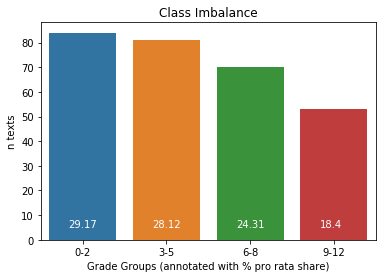

In [15]:
#Visualize potential class imbalance
imbalance=data.Category.value_counts()
sns.barplot([0,1,2,3], imbalance)
plt.xticks([0,1,2,3],['0-2', '3-5', '6-8', '9-12'])
plt.xlabel('Grade Groups (annotated with % pro rata share)')
plt.ylabel('n texts')
plt.title('Class Imbalance')
tot=len(data.Category)
for i in range(4):
    plt.annotate(round(imbalance[i]/tot*(100),2),xy=(i-.17,5), color='white')
plt.show()

In [16]:
data = data.drop(['Grade'], axis=1)

## Data Exploration & Preprocessing

In [17]:
data.Text.head()

0    How Much I Know About Space I had just gone to...
1    My Favorite Pet My cat is fluffy. His name is ...
2    Sweet Spring Spring is sweet because we can go...
3    A Happy Day One day baby Josh came home. He wa...
4    My Trip to Mexico One time I went to Mexico. I...
Name: Text, dtype: object

In [18]:
def tokenize_ (text):
    return word_tokenize(text)

In [19]:
def stopped_ (data):
    stopwords_list = stopwords.words('english') #removing stopwords
    stopwords_list += list(string.punctuation)  #removing punctuation
    data2 = [w.lower() for w in data]
    return([w for w in data2 if (w not in stopwords_list)])

In [20]:
def lemma_(data):
    lemmatizer = WordNetLemmatizer()
    data = [lemmatizer.lemmatize(w) for w in data]     
    return(data)

In [21]:
data['Text_tokenized'] = data.Text.apply(tokenize_)

In [22]:
data['Text_lemmatized'] = data.Text_tokenized.apply(stopped_)

In [23]:
data.Text_lemmatized = data.Text_lemmatized.apply(lemma_)

In [24]:
data.head()

,Text,Category,Text_tokenized,Text_lemmatized
0,How Much I Know About Space I had just gone to...,0-2,"[How, Much, I, Know, About, Space, I, had, jus...","[much, know, space, gone, chobot, space, scien..."
1,My Favorite Pet My cat is fluffy. His name is ...,0-2,"[My, Favorite, Pet, My, cat, is, fluffy, ., Hi...","[favorite, pet, cat, fluffy, name, buzz, favor..."
2,Sweet Spring Spring is sweet because we can go...,0-2,"[Sweet, Spring, Spring, is, sweet, because, we...","[sweet, spring, spring, sweet, go, boat, ridin..."
3,A Happy Day One day baby Josh came home. He wa...,0-2,"[A, Happy, Day, One, day, baby, Josh, came, ho...","[happy, day, one, day, baby, josh, came, home,..."
4,My Trip to Mexico One time I went to Mexico. I...,0-2,"[My, Trip, to, Mexico, One, time, I, went, to,...","[trip, mexico, one, time, went, mexico, blast,..."


#### Column "Text_lemmatized" contains the lemmatized, tokenized texts with stop-words removed and contractions expanded. 

### **Visualization of Corpus**

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 4 columns):
Text               288 non-null object
Category           288 non-null object
Text_tokenized     288 non-null object
Text_lemmatized    288 non-null object
dtypes: object(4)
memory usage: 9.1+ KB


In [26]:
# Create a column containing the number of words per each ORIGINAL text 
data['num_words'] = data['Text'].str.len()  

In [27]:
# Create a column containing average word length for each ORIGINAL text 
temp_token_list = list(data['Text_tokenized'])
new_token_list = []
for item in temp_token_list:
    new_token_list.append(np.average([len(w) for w in item]))
data['avg_orig_word_len'] = new_token_list

In [28]:
# Create a column containing average word length for each LEMMATIZED text 
temp_lemma_list = list(data['Text_lemmatized'])
new_lemma_list = []
for item in temp_lemma_list:
    new_lemma_list.append(np.average([len(w) for w in item]))
data['avg_lem_word_len'] = new_lemma_list

In [29]:
# Review new columns
data.head(5)

,Text,Category,Text_tokenized,Text_lemmatized,num_words,avg_orig_word_len,avg_lem_word_len
0,How Much I Know About Space I had just gone to...,0-2,"[How, Much, I, Know, About, Space, I, had, jus...","[much, know, space, gone, chobot, space, scien...",365,3.641975,5.050000
1,My Favorite Pet My cat is fluffy. His name is ...,0-2,"[My, Favorite, Pet, My, cat, is, fluffy, ., Hi...","[favorite, pet, cat, fluffy, name, buzz, favor...",210,3.000000,4.454545
2,Sweet Spring Spring is sweet because we can go...,0-2,"[Sweet, Spring, Spring, is, sweet, because, we...","[sweet, spring, spring, sweet, go, boat, ridin...",255,3.383333,4.500000
3,A Happy Day One day baby Josh came home. He wa...,0-2,"[A, Happy, Day, One, day, baby, Josh, came, ho...","[happy, day, one, day, baby, josh, came, home,...",131,3.058824,4.235294
4,My Trip to Mexico One time I went to Mexico. I...,0-2,"[My, Trip, to, Mexico, One, time, I, went, to,...","[trip, mexico, one, time, went, mexico, blast,...",243,3.096774,4.892857


In [30]:
#Review descriptive statistics about the corpus before and after preprocessing
print(data.groupby('Category').describe().reset_index().sort_values('Category', ascending=True))

  Category num_words                                                                     \
               count         mean          std    min      25%     50%     75%      max   
0      0-2      84.0   413.523810   285.131484   26.0   185.75   370.0   605.0   1648.0   
1      3-4      70.0  1185.628571   561.531786  121.0   739.25  1227.5  1540.0   2731.0   
2      5-8      81.0  2743.111111  1604.239212  456.0  1859.00  2418.0  3060.0   9705.0   
3     9-12      53.0  4332.943396  2350.536702  755.0  2851.00  3576.0  5434.0  11395.0   

  avg_orig_word_len                                                                        \
              count      mean       std       min       25%       50%       75%       max   
0              84.0  3.503927  0.396866  2.333333  3.244792  3.494681  3.751025  4.625000   
1              70.0  3.527131  0.289879  2.881818  3.361371  3.522176  3.695111  4.606154   
2              81.0  3.781991  0.336416  3.129754  3.533505  3.714286  3.989796  

When looking at the number of words per text, they follow a relatively predicatble pattern, with the min/max, mean, and standard deviation increasing rather significantly with grade-group.  The average length of words per grade-group level does not appear to correlate nearly as much, though; average word lengths are much closer (though they do trend up with grade-group), but standard deviation and word counts do not follow the trend. The visualizations below highlight these differences:

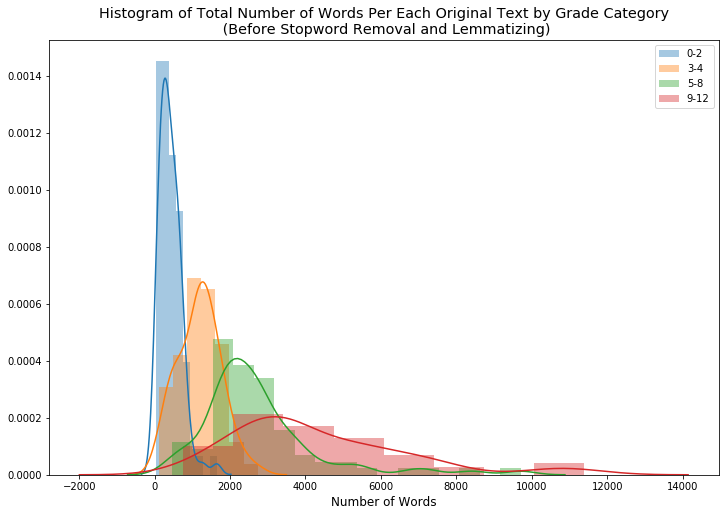

In [31]:
#Histogram of Number of Words per Text
plt.figure(figsize=(12,8))
plt.title('Histogram of Total Number of Words Per Each Original Text by Grade Category\n (Before Stopword Removal and Lemmatizing)', size='x-large')
for name, group in data.groupby('Category'):
    sns.distplot(group['num_words'], label=name)
plt.legend()
plt.xlabel('Number of Words', size='large')
plt.show()

The text lengths for K-2 grade are much shorter than the higher grades. Lengths of middle and high school texts are much more comparable.

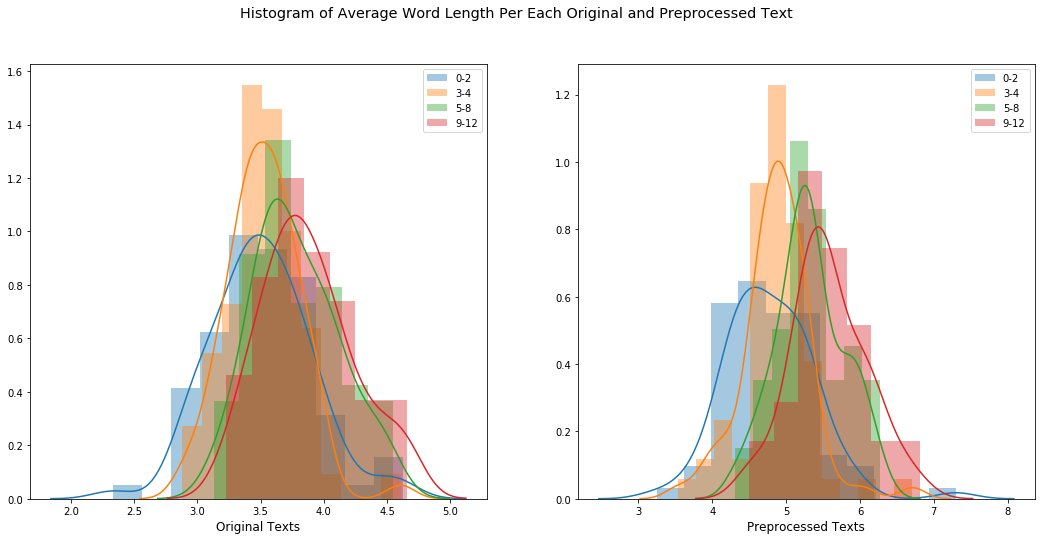

In [32]:
#Visualize distribution of word lengths between original and preprocessed texts


fig, ax = plt.subplots(1,2, figsize=(18, 8))
ax0 = ax[0]
ax1 = ax[1]
for name, group in data.groupby('Category'):
    sns.distplot(group['avg_orig_word_len'], label=name, ax=ax0)
for name, group in data.groupby('Category'):
    sns.distplot(group['avg_lem_word_len'], label=name, ax=ax1)
ax0.set_xlabel('Original Texts', size='large')
ax0.legend()
ax1.set_xlabel('Preprocessed Texts', size='large')
ax1.legend()
fig.suptitle('Histogram of Average Word Length Per Each Original and Preprocessed Text', size='x-large')
plt.show()

    

Overall, there is a LOT of overlap in the distributions between all of the grade-groups, with the most striking being between the upper two.  The distributions of word lengths are much higher in the stopped/lemmatized group (peaking between 4-5 for stopped/lemmatized texts, compared to about 3.5 for the original texts.  The distributions of the original texts are also much closer together, likely due to the inclusion of the stop words. 

# **Weight and Vectorize the Texts**

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    data['Text_lemmatized'],data['Category'],test_size=0.3, random_state=rand_state, stratify=data['Category'])

In [34]:
# Y labels to use with all models
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

pickle_out = open("Mod4_Final_Streamlit/Encoder.pkl", "wb") 
pickle.dump(Encoder, pickle_out) 
pickle_out.close()

### **TD-IDF Weighting**

In [35]:
lemmas = data['Text_lemmatized'].apply(lambda x: ' '.join(x))
lemma_Train_X = X_train.apply(lambda x: ' '.join(x))
lemma_Test_X  = X_test.apply(lambda x: ' '.join(x))

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(lemmas)

# Pickle Tfidf_vect 
pickle_out = open("Mod4_Final_Streamlit/Tfidf_vect.pkl", "wb") 
pickle.dump(Tfidf_vect, pickle_out) 
pickle_out.close()

X_train_tfidf = Tfidf_vect.transform(lemma_Train_X)
X_test_tfidf = Tfidf_vect.transform(lemma_Test_X)

In [36]:
#Use SMOTE to account for class imbalances

sm = SMOTE(sampling_strategy='auto', k_neighbors=2, random_state=rand_state)
X_train_tfidf,y_train_tfidf = sm.fit_resample(X_train_tfidf, y_train) 

In [37]:
pd.DataFrame(X_train_tfidf).shape

(236, 1)

### **Word2vec Vectorization**

In [38]:
num_features=300
model = gensim.models.Word2Vec(data.Text_lemmatized, 
                               size=num_features, 
                               min_count=2, 
                               workers=4, 
                               seed=1, 
                               iter=50, window=5)

In [39]:
model.wv.syn0.shape

(4671, 300)

In [40]:
# Pickle model 
pickle_out = open("Mod4_Final_Streamlit/w2v_model.pkl", "wb") 
pickle.dump(model, pickle_out) 
pickle_out.close()

In [41]:
#Just for fun, to see if it's working
model.wv.doesnt_match("red green bus".split())

'bus'

In [42]:
# Function to average all word vectors in a paragraph (from https://www.kaggle.com/varun08/sentiment-analysis-using-word2vec)
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    return featureVec

In [43]:
# Function for calculating the average feature vector (from https://www.kaggle.com/varun08/sentiment-analysis-using-word2vec)
def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        # Printing a status message every 1000th review
        if counter%1000 == 0:
            print("Review %d of %d"%(counter,len(reviews)))
            
        reviewFeatureVecs[counter] = featureVecMethod(review, model, num_features)
        counter = counter+1
        
    return reviewFeatureVecs

In [44]:
trainDataVecs = getAvgFeatureVecs(X_train, model, num_features)
testDataVecs =  getAvgFeatureVecs(X_test, model, num_features)

Review 0 of 201
Review 0 of 87


In [45]:
trainDataVecs.shape, testDataVecs.shape

((201, 300), (87, 300))

In [46]:
X_train_w2v,y_train_w2v = sm.fit_sample(trainDataVecs, y_train) 

# **Models**

In [47]:
def dummy_classifier(X_train, X_test, y_train, y_test):
  dummy_clf = DummyClassifier(strategy="stratified", random_state=rand_state)
  dummy_clf.fit(X_train, y_train)
  dummy_accuracy = (round(dummy_clf.score(X_test, y_test)*100,3))
  return(dummy_accuracy)

In [48]:
def svm_classifier(X_train, X_test, y_train, y_test):
  """
  Takes in train-test-split for X,y;
  Runs GridSearchCV and then uses the 
  best parameters to run an SVM model
  and returns an Accuracy Score and
  F1 Score.
  """
  clf_svm = svm.SVC(random_state=rand_state)
  param_grid = {'C': [0.1, 1, 10, 100, 1000],  
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                'kernel': ['rbf', 'linear', 'sigmoid', 'poly'],
                'degree': [1,2,3,4]} 
  gs_svm = GridSearchCV(SVC(), param_grid, cv=5)
  gs_svm.fit(X_train,y_train)
  best = gs_svm.best_params_
  SVM = svm.SVC(C=best['C'], kernel=best['kernel'], degree=best['degree'], gamma=best['gamma'], random_state=rand_state)
  SVM.fit(X_train,y_train)
  y_hat = SVM.predict(X_test)
  print('SVM best params:',best)
  return (round(accuracy_score(y_test, y_hat)*100,3), round(f1_score(y_test, y_hat, average='macro')*100,3))

In [49]:
def rf_classifier(X_train, X_test, y_train, y_test):
  """
  Takes in train-test-split for X,y;
  Runs a random forest and returns an 
  Accuracy Score and F1 Score.
  This model was manually tuned using the
  n_estimators parameter during the model
  creation process.
  """
  forest = RandomForestClassifier(n_estimators = 110, random_state=rand_state)
  forest_tf = forest.fit(X_train,y_train)
  y_hat = forest.predict(X_test)
  return (round(accuracy_score(y_test, y_hat)*100,3), round(f1_score(y_test, y_hat, average='macro')*100,3))

In [50]:
def xgb_classifier(X_train, X_test, y_train, y_test):
  """
  Takes in train-test-split for X,y;
  Runs GridSearchCV and then uses the 
  best parameters to run an SVM model
  and returns an Accuracy Score and
  F1 Score.
  """
  clf_xgb = xgb.XGBClassifier(random_state=rand_state)
  param_grid = {'learning_rate': [0.3],  
                'n_estimators': [100,150], 
                'max_depth': [3,6,8],
                'gamma': [0.1,0.4]} 
  gs_xgb = GridSearchCV(clf_xgb, param_grid, cv=5)
  gs_xgb.fit(X_train, y_train)
  best = gs_xgb.best_params_
  XGB = xgb.XGBClassifier(learning_rate=best['learning_rate'], 
                          n_estimators=best['n_estimators'], 
                          max_depth=best['max_depth'],
                          gamma=best['gamma'],
                          random_state=rand_state)
  XGB.fit(X_train, y_train)
  y_hat = XGB.predict(X_test)
  print('XGB best params:',best)
  return (round(accuracy_score(y_test, y_hat)*100,3), round(f1_score(y_test, y_hat, average='macro')*100,3))

In [51]:
try_ = xgb.XGBClassifier(random_state=rand_state)
try_.get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample', 'verbosity'])

In [52]:
def combined_models(X_train, X_test, y_train, y_test):
  """
  Runs all four models used in this notebook, including the 
  dummy classifier, SVM, Random Forest, and XGBoos models.
  Takes full train-test-split for X,y.
  """
  dum = dummy_classifier(X_train, X_test, y_train, y_test)
  svm = svm_classifier(X_train, X_test, y_train, y_test)
  rfc = rf_classifier(X_train, X_test, y_train, y_test)
  xgb = xgb_classifier(X_train, X_test, y_train, y_test)
  print('Dummy Classifier Accuracy:', dum)
  print('SVM Classifier Accuracy, F1 Score (macro):', svm)
  print('Random Forest Accuracy, F1 Score (macro):', rfc)
  print('XG Boost Accuracy, F1 Score (macro):', xgb)
  return()


## **Application of Models to Datasets**

### Iteration 1: Initial, Multi-Source Dataset <br>(don't run these cells after initial dataset is loaded)

In [ ]:
#Test the TF-IDF weighted texts
combined_models(X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test)

Dummy Classifier Accuracy: 19.298
SVM Classifier Accuracy, F1 Score (macro): (38.596, 37.069)
Random Forest Accuracy, F1 Score (macro): (52.632, 50.052)
XG Boost Accuracy, F1 Score (macro): (56.14, 55.472)


()

In [ ]:
#Test the Word2vec vectorized texts
combined_models(X_train_w2v, testDataVecs, y_train_w2v, y_test)

SVM best params: {'C': 1000, 'degree': 1, 'gamma': 0.01, 'kernel': 'sigmoid'}
XGB best params: {'gamma': 0.4, 'learning_rate': 0.3, 'max_depth': 1, 'n_estimators': 100}
Dummy Classifier Accuracy: 19.298
SVM Classifier Accuracy, F1 Score (macro): (52.632, 52.936)
Random Forest Accuracy, F1 Score (macro): (38.596, 39.543)
XG Boost Accuracy, F1 Score (macro): (42.105, 41.757)


()

### Iteration 2: Single-Source, Common-Core Dataset

In [ ]:
#Test the TF-IDF weighted texts
combined_models(X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test)

SVM best params: {'C': 10, 'degree': 1, 'gamma': 0.1, 'kernel': 'rbf'}
XGB best params: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Dummy Classifier Accuracy: 16.129
SVM Classifier Accuracy, F1 Score (macro): (54.839, 33.463)
Random Forest Accuracy, F1 Score (macro): (58.065, 33.75)
XG Boost Accuracy, F1 Score (macro): (61.29, 48.729)


()

In [ ]:
#Test the Word2vec vectorized texts
combined_models(X_train_w2v, testDataVecs, y_train_w2v, y_test)

SVM best params: {'C': 1000, 'degree': 1, 'gamma': 0.1, 'kernel': 'rbf'}
XGB best params: {'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 1, 'n_estimators': 100}
Dummy Classifier Accuracy: 16.129
SVM Classifier Accuracy, F1 Score (macro): (35.484, 32.879)
Random Forest Accuracy, F1 Score (macro): (51.613, 50.397)
XG Boost Accuracy, F1 Score (macro): (41.935, 39.2)


()

### Iteration 3: Combined Dataset

In [ ]:
#Test the TF-IDF weighted texts
combined_models(X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test)

In [ ]:
#Test the Word2vec vectorized texts
combined_models(X_train_w2v, testDataVecs, y_train_w2v, y_test)

The best performing model was the XGBoost on TF-IDF weighted texts, at 63.218% accuracy. This is the model we'll use in production 

# **Final Model** 

### Set up best-functioning models for TF-IDF and Word2vec
<br> (Initial use of TFIDF alone oversimplified)

In [ ]:
clf_xgb_tfidf = xgb.XGBClassifier(gamma=0.1, learning_rate=0.3, max_depth=8, n_estimators=100, random_state=rand_state)
clf_xgb_tfidf.fit(X_train_tfidf, y_train_tfidf)

pickle_out = open("Mod4_Final_Streamlit/clf_xgb_tfidf.pkl", "wb") 
pickle.dump(model, pickle_out) 
pickle_out.close()

#Test to ensure same performance
y_hat = clf_xgb_tfidf.predict(X_test_tfidf)
print(round(accuracy_score(y_test, y_hat)*100,3), round(f1_score(y_test, y_hat, average='macro')*100,3))

In [ ]:
clf_rf_w2v = RandomForestClassifier(n_estimators = 110, random_state=rand_state)
clf_rf_w2v.fit(X_train_w2v, y_train_w2v)

pickle_out = open("Mod4_Final_Streamlit/clf_rf_w2v.pkl", "wb") 
pickle.dump(model, pickle_out) 
pickle_out.close()

#Test to ensure same performance
y_hat2 = clf_rf_w2v.predict(testDataVecs)
print(round(accuracy_score(y_test, y_hat2)*100,3), round(f1_score(y_test, y_hat2, average='macro')*100,3))

# PICKLE OUT THE ABOVE TWO MODELS 1ST TWO LINES ONLY

In [3]:
def preprocess_tfidf(text):
  text1 = tokenize_(text)
  text2 = stopped_(text1)
  text3 = lemma_(text2)
  text4 = [' '.join(text3)]
  text5 = Tfidf_vect.transform(text4)
  return(text5)

In [4]:
def preprocess_w2v(text):
  text1 = tokenize_(text)
  text2 = stopped_(text1)
  text3 = lemma_(text2)
  text4 = [' '.join(text3)]
  text5 = getAvgFeatureVecs(text4, model, num_features)
  return(text5)

### **Input text sample to be predicted:**

In [5]:
text_sample = (input("Paste the text of the student's work here:"))

Paste the text of the student's work here:


In [6]:
predict_me_tfidf = preprocess_tfidf(text_sample)
predict_me_w2v = preprocess_w2v(text_sample)

NameError: name 'tokenize_' is not defined

In [7]:
print('Predicted writing level using TF-IDF weights:',Encoder.inverse_transform(clf_xgb_tfidf.predict(predict_me_tfidf)))
print('Predicted writing level using Word2vec Vectors:',Encoder.inverse_transform(clf_rf_w2v.predict(predict_me_w2v)))

NameError: name 'Encoder' is not defined